# Spatial DFBA Model

This notebook demonstrates a Spatial Dynamic Flux Balance Analysis (DFBA) model, simulating and visualizing biomass concentrations over time in a two-dimensional (2D) field. The model integrates diffusion, advection, and sinking mechanisms to show how these processes influence biomass distributions at each timestep across the grid bins.

**Key components of the notebook:**
- **Initialization**: Setting up the spatial environment with defined bounds, bins, and initial states for molecules and species.
- **Process Simulation**: Using the `SpatialDFBA` class to simulate species growth based on local conditions and kinetic parameters.
- **Diffusion and Advection**: Applying diffusion and advection processes to update molecule concentrations and biomass distributions.
- **Visualization**: Plotting the objective flux and spatial fields to visualize biomass and molecule concentrations over time.

Run the notebook to observe how different species interact and grow in a spatially heterogeneous environment, influenced by diffusion, advection, and sinking mechanisms.


## Imports

In [1]:
# Standard Library Imports
import base64
import io
import logging
import os
import shutil
import warnings

# Third-Party Library Imports
import imageio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from cobra.io import read_sbml_model

# Vivarium Imports
from vivarium.core.engine import Engine
from processes.spatial_dfba import SpatialDFBA

# Project-Specific Imports
from plots.field import plot_objective_flux, plot_fields_temporal


In the following simulation, the user can set the **timesteps**, **species** (for example, E. coli and Alteromonas), and available **molecules** (for example, glucose and oxygen) in each grid bin. Initially, we uniformly distributed molecules and species in the field. Then, we compute the FBA at each timestep for each grid bin for the species in that grid. 

In [4]:
# Configuration
total_time = 200
# Suppress specific warnings
warnings.filterwarnings("ignore", category=UserWarning, module='cobra.util.solver')
warnings.filterwarnings("ignore", message="'' is not a valid SBML 'SId'.")

config = {
    'bounds': [6, 6],  # dimensions of the environment
    'nbins': [3, 3],   # division into bins
    'molecules': ['glucose', 'oxygen'],  # available molecules
    'species_info': [
        {
            'name': 'Alteromonas',
            'model': '../data/Alteromonas_Model.xml',  # Path to FBA model file
            'flux_id_map': {
                'glucose': 'EX_cpd00027_e0',
                'oxygen': 'EX_cpd00007_e0'
            },
            'kinetic_params': {
                'glucose': (0.5, 0.0005),  # Km, Vmax for glucose
                'oxygen': (0.3, 0.0005),   # Km, Vmax for oxygen
            },
            # "fixed_bounds": {
            #     'EX_cpd00149_e0': (-10, 10)  # Setting fixed bounds for Alteromonas
            # }
        },
        {
            'name': 'ecoli',
            'model': '../data/iECW_1372.xml',  # Path to E. coli model file
            'flux_id_map': {
                'glucose': 'EX_glc__D_e',
                'oxygen': 'EX_o2_e'
            },
            'kinetic_params': {
                'glucose': (0.4, 5),  # Km, Vmax for glucose
                'oxygen': (0.25, 0.6),  # Km, Vmax for oxygen
            },
            #     "fixed_bounds": {
            #         'EX_fe3dhbzs_e': (0, 10)  # Setting fixed bounds for E. coli
            # }
        }
    ]
}



# Initialize the process
spatial_dfba = SpatialDFBA(config)

# Initial state configuration
initial_state_config = {
    'random': {
        'glucose': 200,
        'oxygen': 200.0,
        'species': {
            'ecoli': 0.5,
            'Alteromonas': 0.3
        }
    }
}

# Create the initial state
initial_state = spatial_dfba.initial_state(initial_state_config)

#Create the simulation engine
sim = Engine(
    initial_state=initial_state,
    processes={'spatial_dfba': spatial_dfba},
    topology={'spatial_dfba': {
        'fields': ('fields',),
        'species': ('species',),
        'exchange_fluxes': ('exchange_fluxes',),
        'dimensions': ('dimensions',),
    }}
)



# Run the simulation
sim.update(total_time)

# Get the results
data = sim.emitter.get_timeseries()


ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.


Loaded model for Alteromonas
Loaded model for ecoli

Simulation ID: 49be0358-2a63-11ef-9b57-ba21c95c07d9
Created: 06/14/2024 at 11:32:19
Completed in 153.89 seconds


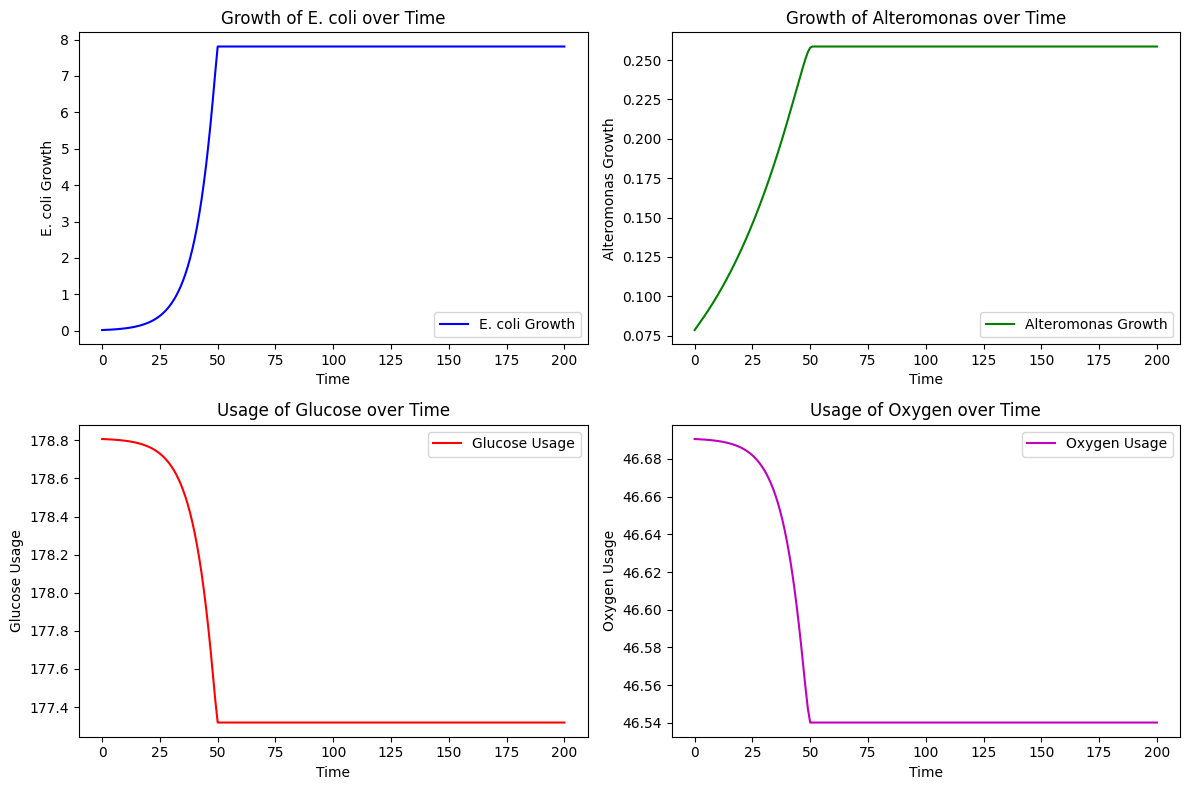

In [5]:
# Extracting the data for plotting
time_points = data["time"]
ecoli_growth = [data["species"]["ecoli"][t][0][0] for t in range(len(time_points))]
alteromonas_growth = [data["species"]["Alteromonas"][t][0][0] for t in range(len(time_points))]
glucose_usage = [data["fields"]["glucose"][t][0][0] for t in range(len(time_points))]
oxygen_usage = [data["fields"]["oxygen"][t][0][0] for t in range(len(time_points))]

# Plotting
plt.figure(figsize=(12, 8))

# Growth of E. coli over time
plt.subplot(2, 2, 1)
plt.plot(time_points, ecoli_growth, label='E. coli Growth', color='b')
plt.xlabel('Time')
plt.ylabel('E. coli Growth')
plt.title('Growth of E. coli over Time')
plt.legend()

# Growth of Alteromonas over time
plt.subplot(2, 2, 2)
plt.plot(time_points, alteromonas_growth, label='Alteromonas Growth', color='g')
plt.xlabel('Time')
plt.ylabel('Alteromonas Growth')
plt.title('Growth of Alteromonas over Time')
plt.legend()

# Usage of glucose over time
plt.subplot(2, 2, 3)
plt.plot(time_points, glucose_usage, label='Glucose Usage', color='r')
plt.xlabel('Time')
plt.ylabel('Glucose Usage')
plt.title('Usage of Glucose over Time')
plt.legend()

# Usage of oxygen over time
plt.subplot(2, 2, 4)
plt.plot(time_points, oxygen_usage, label='Oxygen Usage', color='m')
plt.xlabel('Time')
plt.ylabel('Oxygen Usage')
plt.title('Usage of Oxygen over Time')
plt.legend()

plt.tight_layout()
plt.show()


In [6]:
#objective flux of ecoli from time 0 to 200
d=[data["species"]["ecoli"][t][0][0] for t in range(201)]
d

[0.01949216248159269,
 0.022087053860337456,
 0.024945584992329566,
 0.028174030858892904,
 0.03182025030390524,
 0.03593829093252356,
 0.04058918865317106,
 0.045841870181722075,
 0.05177417179777693,
 0.05847398924205767,
 0.06604057552625267,
 0.07458600553962147,
 0.0842368287063295,
 0.09513593360205104,
 0.10744465140809034,
 0.12134512839827487,
 0.13704300135161657,
 0.15477041389626187,
 0.1747894163509403,
 0.19739579666978158,
 0.22292339564022334,
 0.2517489655473936,
 0.2842976381010135,
 0.3210490744962975,
 0.36254437798257755,
 0.40939385711599124,
 0.46228573575786736,
 0.5219959134919421,
 0.5893988869052935,
 0.6654799472236196,
 0.7513487717326028,
 0.8482545231089326,
 0.9576025588728047,
 1.0809728273644437,
 1.2201399784724651,
 1.3770951330296062,
 1.5540691114766139,
 1.7535566811884191,
 1.9783409747149565,
 2.231516535102435,
 2.516508228503428,
 2.8370810756427,
 3.1973319585053095,
 3.6016461138109706,
 4.054584538094881,
 4.56063067714845,
 5.1236314985143

In [7]:
#Exchange flux of L-Arginine_e0 in Alteromonas from 0 to 200
v=[data['fields']['glucose'][t][0][0] for t in range(201)]
v

[178.80654792320328,
 178.80603006065084,
 178.80546656961258,
 178.80483016636842,
 178.80411141874927,
 178.8032996751561,
 178.80238290709303,
 178.8013475314435,
 178.80017820988027,
 178.79885762248855,
 178.79736621231393,
 178.7956818971359,
 178.79377974430676,
 178.7916316039812,
 178.78920569548725,
 178.7864661409501,
 178.78337243956938,
 178.7798788751644,
 178.77593384873404,
 178.77147912682625,
 178.76644899547284,
 178.7607693083222,
 178.75435641639945,
 178.74711596565427,
 178.73894154714753,
 178.72971318341527,
 178.71929563330218,
 178.7075364964751,
 178.69426409806871,
 178.67928513372135,
 178.66238205599913,
 178.6433101854524,
 178.62179453418767,
 178.59752633826741,
 178.57015930970113,
 178.53930564288962,
 178.50453185016153,
 178.46535456676318,
 178.4212365753424,
 178.37158348624624,
 178.3157418343033,
 178.2529999361033,
 178.18259394436433,
 178.1037236872249,
 178.0155873839234,
 177.91745449751943,
 177.8088212273731,
 177.68976390247755,
 177.56

In [8]:
#Exchange flux of L-Arginine_e0 in Alteromonas from 0 to 200
v=[data["exchange_fluxes"]["Alteromonas"]['EX_cpd00051_e0']["flux"][t][1][1] for t in range(201)]
v

[0.0,
 -1.3617442744046976e-05,
 -1.3957702092571042e-05,
 -1.4306323542087364e-05,
 -1.4663484769561556e-05,
 -1.502936809571246e-05,
 -1.540415529831215e-05,
 -1.5788026759141966e-05,
 -1.6181160446849105e-05,
 -1.6583730705818136e-05,
 -1.699590681530945e-05,
 -1.7417851275953794e-05,
 -1.784971777190479e-05,
 -1.8291648746105337e-05,
 -1.8743772512663373e-05,
 -1.920619981353705e-05,
 -1.967901970561868e-05,
 -2.0162294637632696e-05,
 -2.065605454228878e-05,
 -2.1160289725563108e-05,
 -2.167494227869624e-05,
 -2.2199895665152226e-05,
 -2.2734962038473373e-05,
 -2.3279866719301562e-05,
 -2.3834229089086117e-05,
 -2.439753892732708e-05,
 -2.4969126904304652e-05,
 -2.554812750661114e-05,
 -2.6133432065694033e-05,
 -2.6723628700868436e-05,
 -2.731692475687822e-05,
 -2.7911045524473325e-05,
 -2.850310038421865e-05,
 -2.9089403532001277e-05,
 -2.9665230345956835e-05,
 -3.0224480923304656e-05,
 -3.075920708923584e-05,
 -3.1258934265739483e-05,
 -3.170966774106772e-05,
 -3.209240055778522e

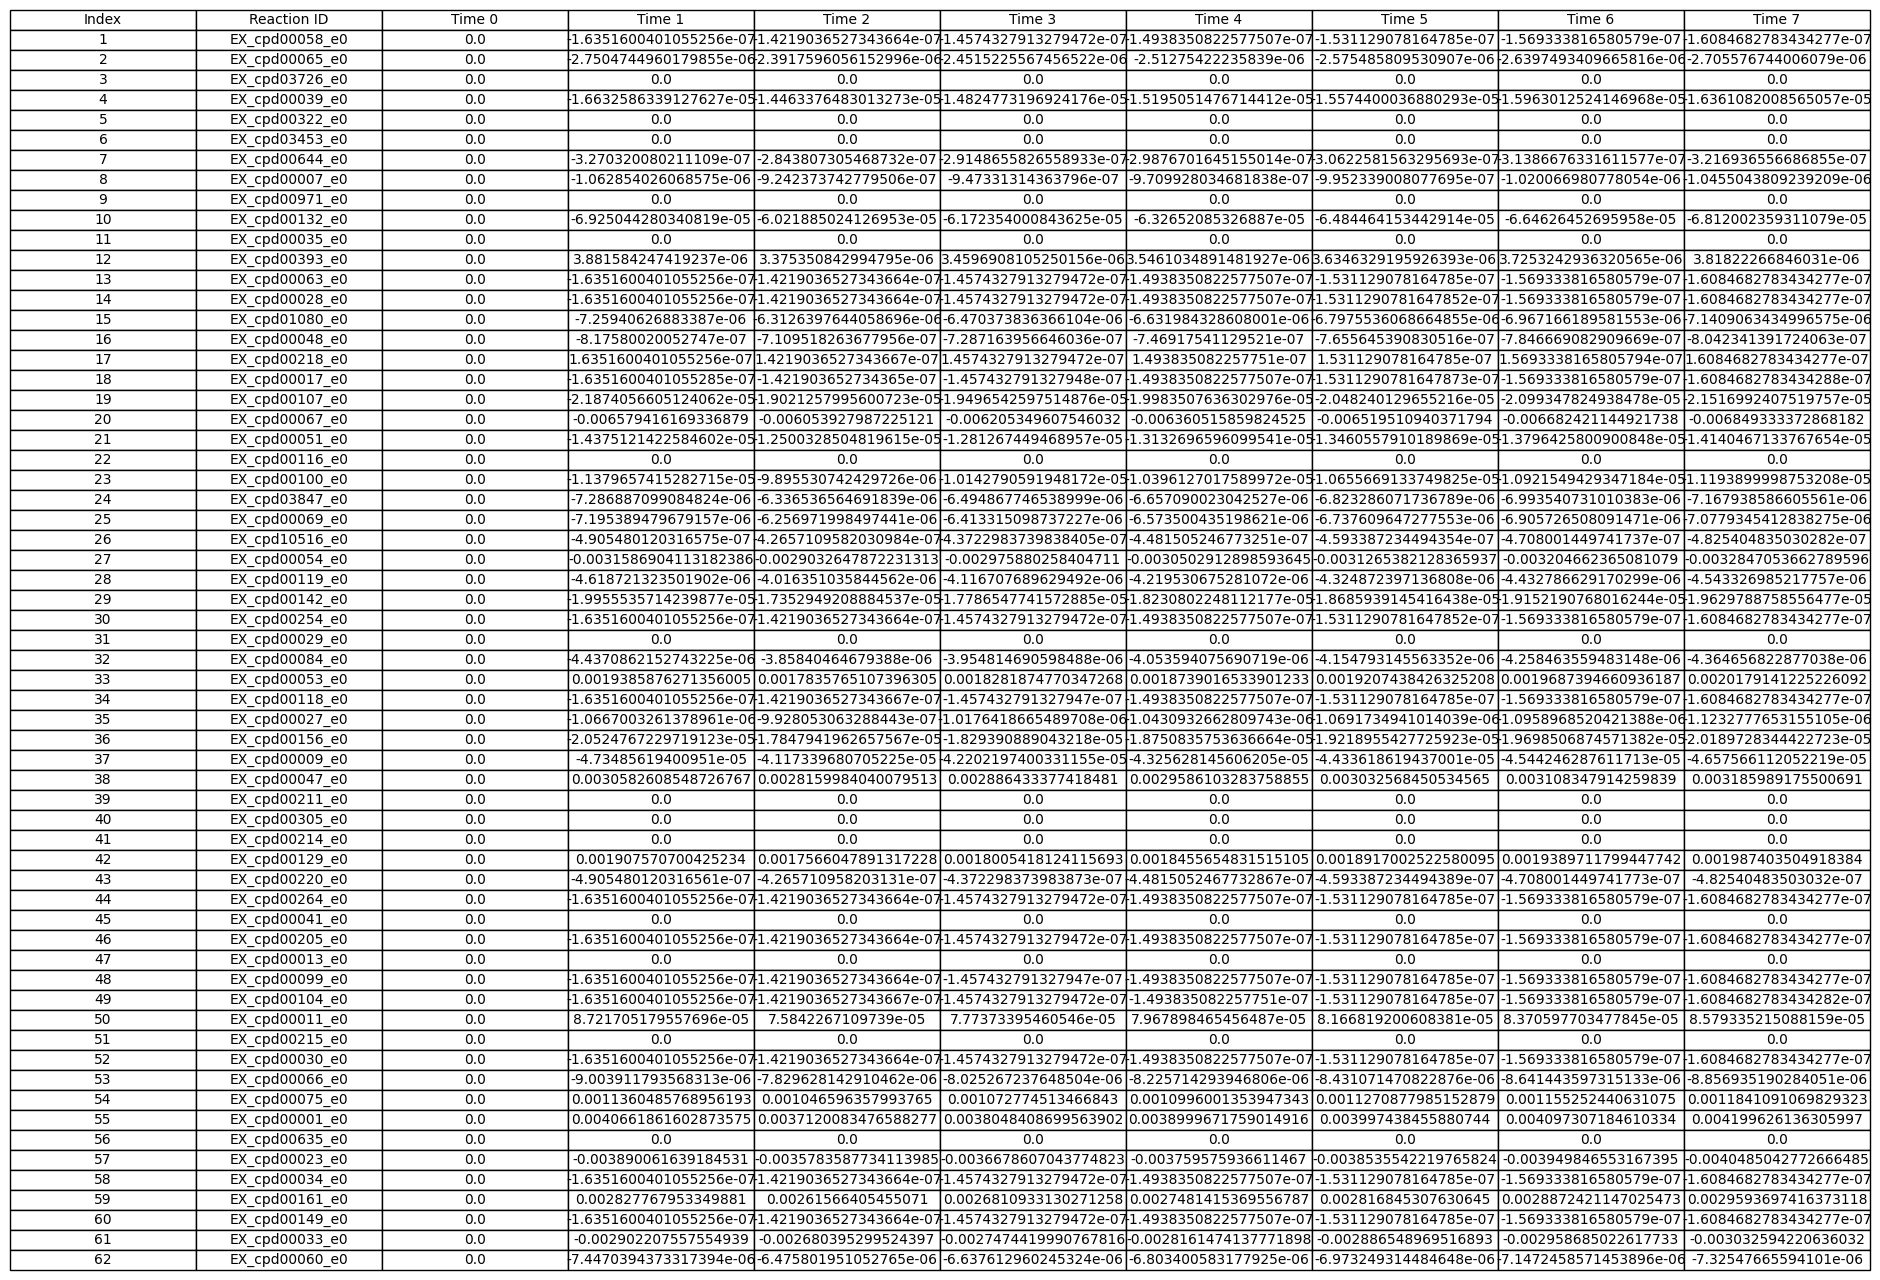

In [9]:
# Exchange fluxes of Alteromonas in the first 7 timesteps. 
time_steps = range(8)
reaction_ids = list(data["exchange_fluxes"]['Alteromonas'].keys())

# Create a dictionary to hold the flux values for each reaction ID
flux_data = {'Index': range(1, len(reaction_ids) + 1), 'Reaction ID': reaction_ids}

for t in time_steps:
    flux_data[f'Time {t}'] = [data["exchange_fluxes"]['Alteromonas'][reaction_id]["flux"][t][0][0] for reaction_id in reaction_ids]

# Create a DataFrame
df = pd.DataFrame(flux_data)

# Display the DataFrame as a table
fig, ax = plt.subplots(figsize=(20, 10))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

plt.show()


In the following code snippet, user can provide the reaction ID and see the Reaction Name, Reaction Equation, Lower Bound, and Upper Bound.

In [10]:
# Define the reaction ID you want to retrieve information for
reaction_id = 'EX_cpd00161_e0'

# Retrieve the details for the specified reaction ID
reaction_details = data["exchange_fluxes"]['Alteromonas'][reaction_id]

# Extract and print the reaction details
reaction_name = reaction_details['name'][0]
reaction_equation = reaction_details['reaction'][0]
lower_bound = reaction_details['lower_bound'][0]
upper_bound = reaction_details['upper_bound'][0]

print(f"Reaction ID: {reaction_id}")
print(f"Reaction Name: {reaction_name}")
print(f"Reaction Equation: {reaction_equation}")
print(f"Lower Bound: {lower_bound}")
print(f"Upper Bound: {upper_bound}")


Reaction ID: EX_cpd00161_e0
Reaction Name: Exchange for L-Threonine_e0
Reaction Equation: cpd00161_e0 <=> 
Lower Bound: -1000.0
Upper Bound: 1000.0


The first row of the following plots shows the biomass for each species at each time step in each grid bin. It also shows the overall biomass (biomass of all present species). The bottom row shows the concentration of molecules in the environment at each grid bin at each time step.

/var/folders/wc/w8xfpkvd1gq1szrqlrsy0cy40000gn/T/ipykernel_29701/16197986.py:57: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(buf))
/var/folders/wc/w8xfpkvd1gq1szrqlrsy0cy40000gn/T/ipykernel_29701/16197986.py:103: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(buf))
/var/folders/wc/w8xfpkvd1gq1szrqlrsy0cy40000gn/T/ipykernel_29701/16197986.py:114: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `im


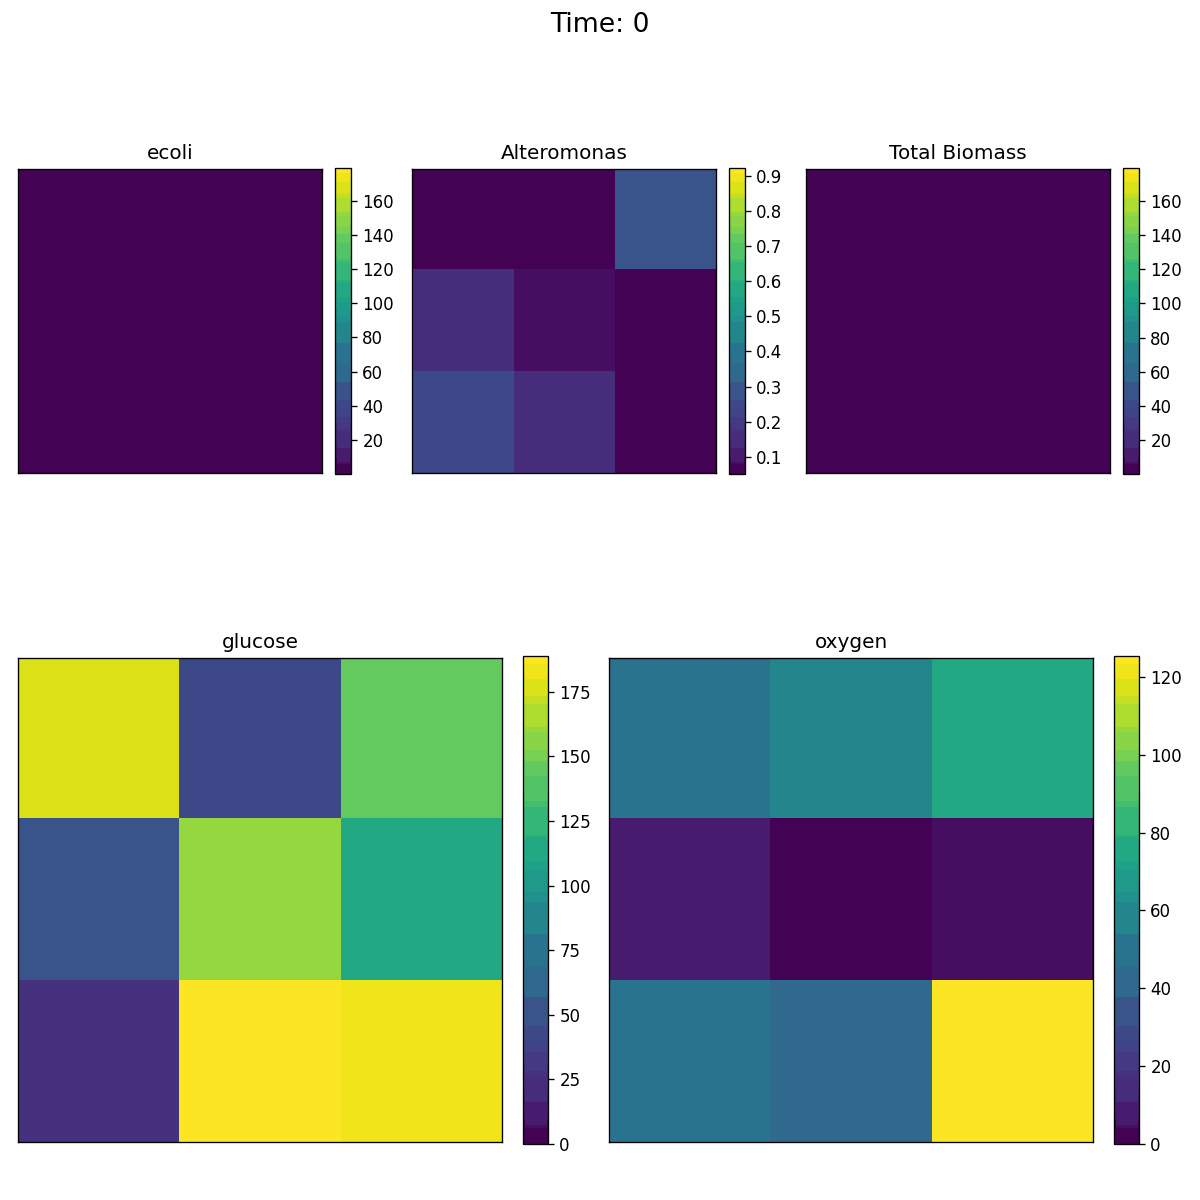

In [11]:
def plot_objective_flux_to_gif(data, total_time, species_names, temp_dir):
    available_time_points = data["time"]
    valid_time_points = list(range(total_time + 1))

    num_species = len(species_names)
    num_times = len(valid_time_points)
    images = []

    # Calculate global min and max for each species and total biomass
    global_min = [np.inf] * (num_species + 1)  # +1 for total biomass
    global_max = [-np.inf] * (num_species + 1)

    # Precompute global min/max for species and total biomass
    for time in valid_time_points:
        time_index = data["time"].index(time)
        total_biomass = np.zeros_like(data["species"][species_names[0]][time_index])

        for j, species_id in enumerate(species_names):
            current_species = data["species"][species_id][time_index]
            total_biomass += current_species
            global_min[j] = min(global_min[j], np.min(current_species))
            global_max[j] = max(global_max[j], np.max(current_species))

        # Update total biomass global min and max
        global_min[-1] = min(global_min[-1], np.min(total_biomass))
        global_max[-1] = max(global_max[-1], np.max(total_biomass))

    # Plotting each species and total biomass for each time
    for time in valid_time_points:
        time_index = data["time"].index(time)
        total_biomass = np.zeros_like(data["species"][species_names[0]][time_index])
        fig, axs = plt.subplots(1, num_species + 1, figsize=(num_species * 5, 5), squeeze=False)

        for j, species_id in enumerate(species_names):
            current_species = data["species"][species_id][time_index]
            total_biomass += current_species
            im = axs[0, j].imshow(current_species, cmap='viridis', vmin=global_min[j], vmax=global_max[j])
            axs[0, j].set_title(species_id)
            axs[0, j].set_xticks([])
            axs[0, j].set_yticks([])
            plt.colorbar(im, ax=axs[0, j], fraction=0.046, pad=0.04)

        # Plot total biomass in the last column
        im = axs[0, -1].imshow(total_biomass, cmap='viridis', vmin=global_min[-1], vmax=global_max[-1])
        axs[0, -1].set_title("Total Biomass")
        axs[0, -1].set_xticks([])
        axs[0, -1].set_yticks([])
        plt.colorbar(im, ax=axs[0, -1], fraction=0.046, pad=0.04)

        # Add the current time as text
        plt.suptitle(f'Time: {time}', fontsize=16)

        plt.tight_layout()
        buf = io.BytesIO()
        plt.savefig(buf, format='png', dpi=120)
        buf.seek(0)
        images.append(imageio.imread(buf))
        buf.close()
        plt.close(fig)

    # Save images to temporary directory
    for i, img in enumerate(images):
        imageio.imwrite(os.path.join(temp_dir, f'obj_flux_{i}.png'), img)

def plot_molecules_to_gif(data, total_time, molecule_names, temp_dir):
    available_time_points = data["time"]
    valid_time_points = list(range(total_time + 1))

    num_molecules = len(molecule_names)
    num_times = len(valid_time_points)
    images = []

    # Calculate global min and max for each molecule
    global_min = [np.inf] * num_molecules
    global_max = [-np.inf] * num_molecules

    # Precompute global min/max for molecule concentrations
    for time in valid_time_points:
        time_index = data["time"].index(time)

        for j, molecule_id in enumerate(molecule_names):
            current_molecule = data["fields"][molecule_id][time_index]
            global_min[j] = min(global_min[j], np.min(current_molecule))
            global_max[j] = max(global_max[j], np.max(current_molecule))

    # Plotting each molecule concentration for each time
    for time in valid_time_points:
        time_index = data["time"].index(time)
        fig, axs = plt.subplots(1, num_molecules, figsize=(num_molecules * 5, 5), squeeze=False)

        for j, molecule_id in enumerate(molecule_names):
            current_molecule = data["fields"][molecule_id][time_index]
            im = axs[0, j].imshow(current_molecule, cmap='viridis', vmin=global_min[j], vmax=global_max[j])
            axs[0, j].set_title(molecule_id)
            axs[0, j].set_xticks([])
            axs[0, j].set_yticks([])
            plt.colorbar(im, ax=axs[0, j], fraction=0.046, pad=0.04)

        plt.tight_layout()
        buf = io.BytesIO()
        plt.savefig(buf, format='png', dpi=120)
        buf.seek(0)
        images.append(imageio.imread(buf))
        buf.close()
        plt.close(fig)

    # Save images to temporary directory
    for i, img in enumerate(images):
        imageio.imwrite(os.path.join(temp_dir, f'molecule_{i}.png'), img)

def combine_gifs(output_filename, temp_dir, num_images):
    combined_images = []
    for i in range(num_images):
        obj_flux_img = imageio.imread(os.path.join(temp_dir, f'obj_flux_{i}.png'))
        molecule_img = imageio.imread(os.path.join(temp_dir, f'molecule_{i}.png'))
        
        combined_img = np.vstack((obj_flux_img, molecule_img))
        combined_images.append(combined_img)

    imageio.mimsave(output_filename, combined_images, duration=0.5, loop=0)

    # Optionally display the GIF in a Jupyter notebook
    with open(output_filename, 'rb') as file:
        data = file.read()
        data_url = 'data:image/gif;base64,' + base64.b64encode(data).decode()
    display(HTML(f'<img src="{data_url}" alt="Combined GIF" style="max-width:100%;"/>'))

# Create a temporary directory
temp_dir = 'temp_images'
os.makedirs(temp_dir, exist_ok=True)

# Generate images
plot_objective_flux_to_gif(data, total_time=200, species_names=['ecoli', 'Alteromonas'], temp_dir=temp_dir)
plot_molecules_to_gif(data, total_time=200, molecule_names=['glucose', 'oxygen'], temp_dir=temp_dir)

# Combine GIFs
combine_gifs('combined_over_time.gif', temp_dir, total_time + 1)

# Clean up temporary directory
shutil.rmtree(temp_dir)


Exchange reactions and objective fluxes of the model when the user sets an exchange flux to zero.

In [12]:
def print_exchange_fluxes(sbml_path):
    # Load the model from the SBML file
    model = read_sbml_model(sbml_path)
    
    # Set the flux of EX_cpd00027_e0 to zero
    reaction_id_to_set_zero = 'EX_cpd00027_e0'
    if reaction_id_to_set_zero in model.reactions:
        model.reactions.get_by_id(reaction_id_to_set_zero).lower_bound = 0
        model.reactions.get_by_id(reaction_id_to_set_zero).upper_bound = 0
    else:
        print(f"Reaction {reaction_id_to_set_zero} not found in the model.")
    
    # Optimize the model
    solution = model.optimize()
    
    # Print the objective flux
    print("Objective flux:", solution.objective_value)
    
    # Print the list of exchange reactions and their flux values
    exchange_reactions = model.exchanges
    print("Exchange reactions and their flux values:")
    for reaction in exchange_reactions:
        flux_value = solution.fluxes[reaction.id]
        print(f"ID: {reaction.id}, Name: {reaction.name}, Reaction: {reaction.reaction}, Flux value: {flux_value}")

# Example usage
sbml_path = '../data/Alteromonas_Model.xml'
print_exchange_fluxes(sbml_path)


ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.


Objective flux: 66.07455267127095
Exchange reactions and their flux values:
ID: EX_cpd00058_e0, Name: Exchange for Cu2+_e0, Reaction: cpd00058_e0 <=> , Flux value: -0.18541571119438544
ID: EX_cpd00065_e0, Name: Exchange for L-Tryptophan_e0, Reaction: cpd00065_e0 <=> , Flux value: -3.118845692732816
ID: EX_cpd03726_e0, Name: Exchange for Fe-enterochlin_e0, Reaction: cpd03726_e0 <=> , Flux value: 0.0
ID: EX_cpd00039_e0, Name: Exchange for L-Lysine_e0, Reaction: cpd00039_e0 <=> , Flux value: -18.86018951926165
ID: EX_cpd00322_e0, Name: Exchange for L-Isoleucine_e0, Reaction: cpd00322_e0 <=> , Flux value: -15.976728407112487
ID: EX_cpd03453_e0, Name: Exchange for Enterobactin_e0, Reaction: cpd03453_e0 <=> , Flux value: 0.0
ID: EX_cpd00644_e0, Name: Exchange for PAN_e0, Reaction: cpd00644_e0 <=> , Flux value: -0.3708314223887559
ID: EX_cpd00007_e0, Name: Exchange for O2_e0, Reaction: cpd00007_e0 <=> , Flux value: -626.102965839712
ID: EX_cpd00971_e0, Name: Exchange for Na+_e0, Reaction: cpd